In [0]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'memotion_analysis/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_dataframe = pd.read_csv('/content/train.csv')
del train_dataframe['OCR_extracted_text']
train_dataframe

,Image_name,Image_URL,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment
0,10_year_2r94rv.jpg,https://i.imgflip.com/2r94rv.jpg,look friend lightyear sohalikut trend play 10 ...,0.000000,0.000000,0.000000,0.0,very_positive
1,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,best 10 yearchallenge completed less 4 kudus ...,0.333333,0.000000,0.000000,1.0,very_positive
2,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,https://www.lifewire.com/thmb/8wNfd94_meE9X2cp...,sam thorne follow follow saw everyone postin...,0.666667,0.166667,0.000000,0.0,positive
3,10_year_10-year-challenge-sweet-dee-edition-40...,https://pics.conservativememes.com/10-year-cha...,10 year challenge sweet dee edition,0.666667,0.333333,0.333333,1.0,positive
4,10_year_10-year-challenge-with-no-filter-47-hi...,https://pics.me.me/10-year-challenge-with-no-f...,10 year challenge filter 47 hilarious 10 year ...,0.000000,0.500000,0.333333,0.0,neutral
...,...,...,...,...,...,...,...,...
6580,best_2017_d2fe668a7ff9227fbb604927de025311.jpg,https://i.pinimg.com/345x/d2/fe/66/d2fe668a7ff...,tuesday mardi gras wednesday valentine friday ...,0.666667,0.333333,0.333333,1.0,neutral
6581,best_2017_DR9DnutV4AYK-Pc.jpg,https://pbs.twimg.com/media/DR9DnutV4AYK-Pc.jpg,must watch movies 2017 iti chennai memes maana...,1.000000,0.333333,0.000000,0.0,neutral
6582,best_2017_less-more-talking-listening-planning...,https://pics.ballmemes.com/less-more-talking-l...,less talking planning soda junk food complaini...,1.000000,0.000000,0.666667,0.0,positive
6583,best_2017_make-time.jpg,https://arhtisticlicense.files.wordpress.com/2...,time one time unless make,0.333333,0.333333,0.000000,1.0,very_positive


In [0]:
%cd 'gdrive'
%cd 'My Drive'
!mkdir memotion_analysis
%cd 'memotion_analysis'
!mkdir dataset
%cd 'dataset'
!mkdir train
%cd 'train'
!mkdir positive
!mkdir negative
!mkdir neutral

/content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/memotion_analysis
/content/gdrive/My Drive/memotion_analysis/dataset
/content/gdrive/My Drive/memotion_analysis/dataset/train


In [0]:
import urllib


opener=urllib.request.build_opener()
opener.addheaders=[('User-Agent', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)


**Data Extraction**
Images will be downloaded and saved in folders based in their overall sentiments.




In [0]:
from os.path import join
import os

TRAIN_BASE_PATH = base_dir + 'dataset/train/'
negatives = ['negative', 'very_nagetive']
positives = ['positive', 'very_positive']
negative_memes, positive_memes, neutral_memes = [], [], []

for index, row in train_dataframe.iterrows():
  url = row['Image_URL']
  file_name = row['Image_name']
  filepath = TRAIN_BASE_PATH + 'negative/' if row['Overall_Sentiment'] in negatives \
      else TRAIN_BASE_PATH + 'positive/' if row['Overall_Sentiment'] in positives \
      else TRAIN_BASE_PATH + 'neutral/'
      
  filepath = join(filepath, file_name)
  if os.path.isfile(filepath):
    continue

  else:
    try:
      urllib.request.urlretrieve(url, filepath)

      if row['Overall_Sentiment'] in negatives:
        negative_memes += [{'text': row['corrected_text'], 'filepath': filepath, 'humour': row['Humour'],
                          'sarcasm': row['Sarcasm'], 'offensive': row['offensive'],
                          'motivational': row['Motivational']}]

      elif row['Overall_Sentiment'] in positives:
        positive_memes += [{'text': row['corrected_text'], 'filepath': filepath, 'humour': row['Humour'],
                          'sarcasm': row['Sarcasm'], 'offensive': row['offensive'],
                          'motivational': row['Motivational']}]
      else:
        neutral_memes += [{'text': row['corrected_text'], 'filepath': filepath, 'humour': row['Humour'],
                          'sarcasm': row['Sarcasm'], 'offensive': row['offensive'],
                          'motivational': row['Motivational']}]

    except Exception as e:
      print(e)

<urlopen error [Errno -5] No address associated with hostname>
HTTP Error 522: Origin Connection Time-out
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -3] Temporary failure in name resolution>
<urlopen error [Errno -5] No address associated with hostname>
HTTP Error 522: Origin Connection Time-out
URL can't contain control characters. '/teepublic/image/private/s--2w_Lv3Ck--/t_Preview/b_rgb:ffffff,BE AWESOME ,BE AWESOME ,funny,general,not_offensive,not_motivational,very_positive\nbarney_828175a7b5e839a944f76ee7f44d43a6.jpg,https://i.pinimg.com/originals/82/81/75/828175a7b5e839a944f76ee7f44d43a6.jpg,AWESOME How my friends see me How my family How society sees sees me me How my camera sees me How I see me How I really am ,AWESOME How my friends see me How my family How society sees sees me me How my camera sees me How I see 

In [0]:
negetives_dataframe = pd.DataFrame(negative_memes)
positive_dataframe = pd.DataFrame(positive_memes)
neutral_dataframe = pd.DataFrame(neutral_memes)

In [0]:
negetives_dataframe.to_csv('negatives_1.csv')
positive_dataframe.to_csv('positives_1.csv')
neutral_dataframe.to_csv('neutral_1.csv')

In [0]:
%cd 'train'
%cd 'positive'
print('number of positive memes:')
!ls -1 | wc -l

%cd '..'
%cd 'negative'
print('number of negative memes:')
!ls -1 | wc -l

%cd '..'
%cd 'neutral'
print('number of neutral memes:')
!ls -1 | wc -l



[Errno 2] No such file or directory: 'train'
/content/gdrive/My Drive/memotion_analysis/dataset/train
/content/gdrive/My Drive/memotion_analysis/dataset/train/positive
number of positive memes:
3544
/content/gdrive/My Drive/memotion_analysis/dataset/train
/content/gdrive/My Drive/memotion_analysis/dataset/train/negative
number of negative memes:
400
/content/gdrive/My Drive/memotion_analysis/dataset/train
/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral
number of neutral memes:
2027


614 images could not be downloaded. Totally 5971 positive, negative and neutral memes are downloaded and saved into seperate csv files.

**Train and validation datasets**
We now create the train and validation datasets required for learning.

In [0]:
negatives_dataframe = pd.read_csv('/content/gdrive/My Drive/memotion_analysis/dataset/negatives_1.csv')
positive_dataframe = pd.read_csv('/content/gdrive/My Drive/memotion_analysis/dataset/positives_1.csv')
neutral_dataframe = pd.read_csv('/content/gdrive/My Drive/memotion_analysis/dataset/neutral_1.csv')

negatives_dataframe['Overall_Sentiment'] = 0
neutral_dataframe['Overall_Sentiment'] = 1
positive_dataframe['Overall_Sentiment'] = 2

memes_dataframe = pd.concat([negatives_dataframe, neutral_dataframe, positive_dataframe], axis=0, ignore_index=True)
memes_dataframe = memes_dataframe.sample(frac=1).reset_index(drop=True)
memes_dataframe = memes_dataframe.loc[:, ~memes_dataframe.columns.str.contains('^Unnamed')]
memes_dataframe

,text,filepath,humour,sarcasm,offensive,motivational,Overall_Sentiment
0,never let bullshit stress success club,/content/gdrive/My Drive/memotion_analysis/dat...,0.666667,0.000000,0.333333,0.0,2
1,moment find perfect avocado supermarket,/content/gdrive/My Drive/memotion_analysis/dat...,0.000000,0.000000,0.666667,1.0,2
2,fans get clear view cheryl bump,/content/gdrive/My Drive/memotion_analysis/dat...,0.666667,0.333333,0.666667,0.0,1
3,u ask allow fix fuckup ask offer even think...,/content/gdrive/My Drive/memotion_analysis/dat...,0.666667,0.166667,0.000000,0.0,2
4,life episode friends ross drinks margaritas ...,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.333333,0.333333,1.0,1
...,...,...,...,...,...,...,...
5966,join houses,/content/gdrive/My Drive/memotion_analysis/dat...,0.000000,0.000000,0.333333,1.0,1
5967,finding nemo better shark tale millenials elde...,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.000000,0.666667,1.0,2
5968,trump putin like ashford simpson theyre solid ...,/content/gdrive/My Drive/memotion_analysis/dat...,0.000000,0.000000,0.666667,1.0,2
5969,top dont ever disinfect taxi,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.333333,0.666667,1.0,1


In [0]:
memes_dataframe.to_csv('/content/gdrive/My Drive/memotion_analysis/dataset/train.csv')



```
# This is formatted as code
```

**Loading images**
Now we save images and other of features required for network learning into lists.

In [0]:
train_dataframe = pd.read_csv('/content/gdrive/My Drive/memotion_analysis/dataset/train.csv')
train_dataframe = train_dataframe.loc[:, ~train_dataframe.columns.str.contains('^Unnamed')]
train_dataframe = train_dataframe.dropna(subset=['text'])

In [0]:
train_test_factor = 0.7
mask = np.random.rand(len(train_dataframe)) < train_test_factor
validation_dataframe = train_dataframe[~mask]
train_dataframe = train_dataframe[mask]

In [0]:
train_dataframe

,text,filepath,humour,sarcasm,offensive,motivational,Overall_Sentiment
0,never let bullshit stress success club,/content/gdrive/My Drive/memotion_analysis/dat...,0.666667,0.000000,0.333333,0.0,2
3,u ask allow fix fuckup ask offer even think...,/content/gdrive/My Drive/memotion_analysis/dat...,0.666667,0.166667,0.000000,0.0,2
4,life episode friends ross drinks margaritas ...,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.333333,0.333333,1.0,1
5,said could become solbecame snowball,/content/gdrive/My Drive/memotion_analysis/dat...,0.000000,0.333333,1.000000,1.0,2
6,life goals sexism patriarchy unsafe roads fuzi...,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.000000,0.666667,1.0,2
...,...,...,...,...,...,...,...
5965,look tuck chin sink rnc come back us 90s ji...,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.000000,0.666667,0.0,1
5966,join houses,/content/gdrive/My Drive/memotion_analysis/dat...,0.000000,0.000000,0.333333,1.0,1
5967,finding nemo better shark tale millenials elde...,/content/gdrive/My Drive/memotion_analysis/dat...,1.000000,0.000000,0.666667,1.0,2
5968,trump putin like ashford simpson theyre solid ...,/content/gdrive/My Drive/memotion_analysis/dat...,0.000000,0.000000,0.666667,1.0,2


**Loading images**
Now we save images and other of features required for network learning into lists.

In [6]:
from keras.preprocessing import image as keras_image


def preprocess_image(image):
  img = image.copy()
  img = keras_image.img_to_array(img)
  img = img//255.0

  return img

Using TensorFlow backend.


In [0]:
train_list = train_dataframe.to_dict('records')
validation_list = validation_dataframe.to_dict('records')

In [8]:
xs_images = {'train': [], 'validation': []}
xs_categoricals = {'train': [], 'validation': []}
xs_texts = {'train': [], 'validation': []}
ys = {'train': [], 'validation': []}

for image_data in train_list:
  try:
    image = keras_image.load_img(image_data['filepath'], target_size=(224, 224))
  except Exception as e:
    print(e)
    continue

  image = preprocess_image(image)
  xs_images['train'].append(image)
  xs_texts['train'].append(image_data['text'])
  humour = image_data['humour']
  sarcasm = image_data['sarcasm']
  offensive = image_data['offensive']
  motivational = image_data['motivational']
  xs_categoricals['train'].append([humour, sarcasm, offensive, motivational])
  ys['train'] += [image_data['Overall_Sentiment']]

for image_data in validation_list:
  try:
    image = keras_image.load_img(image_data['filepath'], target_size=(224, 224))
  except Exception as e:
    print(e)
    continue
    
  image = preprocess_image(image)
  xs_images['validation'].append(image)
  xs_texts['validation'].append(image_data['text'])
  humour = image_data['humour']
  sarcasm = image_data['sarcasm']
  offensive = image_data['offensive']
  motivational = image_data['motivational']
  xs_categoricals['validation'].append([humour, sarcasm, offensive, motivational])
  ys['validation'] += [image_data['Overall_Sentiment']]


cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/sexist_meme4_640x700.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/gene_85YOUR-ARGUMENT-IS-INVALID-meme-collection-1mut.com-1.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/minion_Minion-gift-to-baby-ghost-halloween-meme-635x529.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral/minion_funny-minions-03000o-5.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/best_2017_meme-costumes-2017-great-funny-halloween-costumes-2017-memes-of-meme-costumes-2017.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/jim_got-to-love-jim-carrey_gp_2415921.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/gene_59157598.jp

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral/spiderman_60s-spiderman-meme-collection-1mut.com-8.png'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral/bean_whats-is-the-face-expression-of-mr-bean-hahahah-mr-bean-meme-on-me.png'


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/jim_alright_y_then_by_girlgamer1397-d5kyqxy.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/bean_mr-bean-face-imgflip.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/best_2017_meme-costumes-2017-admirable-2017-pun-halloween-costume-ideas-saltypun-of-meme-costumes-2017.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/negative/third_Skeptical-Third-World-Kid-meme-collection-1mut.com-16.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/harvey_14.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/chuck_Hilarious-Chuck-Norris-Memes-Ever-2-1024x671.png'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/minion_66c264447c7

In [0]:
# Sanity check
assert (len(ys['train']) == len(xs_images['train']) == len(xs_texts['train']) == len(xs_categoricals['train'])),"There is some problem."
assert (len(ys['validation']) == len(xs_images['validation']) == len(xs_texts['validation']) == len(xs_categoricals['validation'])),"There is some problem."

**Word2Vec Embedding** Now its time to embed texts using pre-trainded embedding model Word2Vec.

In [10]:
# Find texts maximum length
MAX_SEQUENCE_LENGTH = 0
for image_data in train_list:
  MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, len(image_data['text'].split(' ')))

for image_data in validation_list:
  MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH, len(image_data['text'].split(' ')))

print(MAX_SEQUENCE_LENGTH)

104


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip
!cp -a 'glove.6B.100d.txt' 'gdrive/My Drive/memotion_analysis/word2vec/'

--2020-01-23 14:18:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-23 14:18:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-23 14:18:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
all_texts = xs_texts['train'] + xs_texts['validation']

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NB_WORDS = 10000

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(all_texts)
train_sequences = tokenizer.texts_to_sequences(xs_texts['train'])
validation_sequences = tokenizer.texts_to_sequences(xs_texts['validation'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

xs_texts['train'] = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
ys['train'] = to_categorical(np.asarray(ys['train']))
print('Shape of train data tensor:', xs_texts['train'].shape)
print('Shape of train label tensor:', ys['train'].shape)

xs_texts['validation'] = pad_sequences(validation_sequences, maxlen=MAX_SEQUENCE_LENGTH)
ys['validation'] = to_categorical(np.asarray(ys['validation']))
print('Shape of validation train data tensor:', xs_texts['validation'].shape)
print('Shape of validation train label tensor:', ys['validation'].shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 10844 unique tokens.
Shape of train data tensor: (4197, 104)
Shape of train label tensor: (4197, 3)
Shape of validation train data tensor: (1755, 104)
Shape of validation train label tensor: (1755, 3)


In [13]:
import os


embeddings_index = {}

f = open('gdrive/My Drive/memotion_analysis/word2vec/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [0]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector



**Building up the model** Now we create our baseline network using keras functional APIs and pre-trained CNN using VGG16 model.

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate
from keras.models import Model
from keras import regularizers


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
lstm = LSTM(128, return_sequences=True)(embedded_sequences)
lstm = LSTM(128, return_sequences=True)(lstm)
lstm = LSTM(128)(lstm)

categorical_input = Input(shape=(4,))
x = Dense(128, activation='relu')(categorical_input)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)


image_input = Input(shape=(224, 224, 3))
y = Conv2D(32, (3, 3), activation='relu')(image_input)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(128, (3, 3), activation='relu')(y)
y = Conv2D(128, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)

merged = concatenate([lstm, x, y])
x = Dense(128, activation='relu')(merged)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=[sequence_input, categorical_input, image_input], outputs=[output])


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 220, 220, 64) 18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 110, 110, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

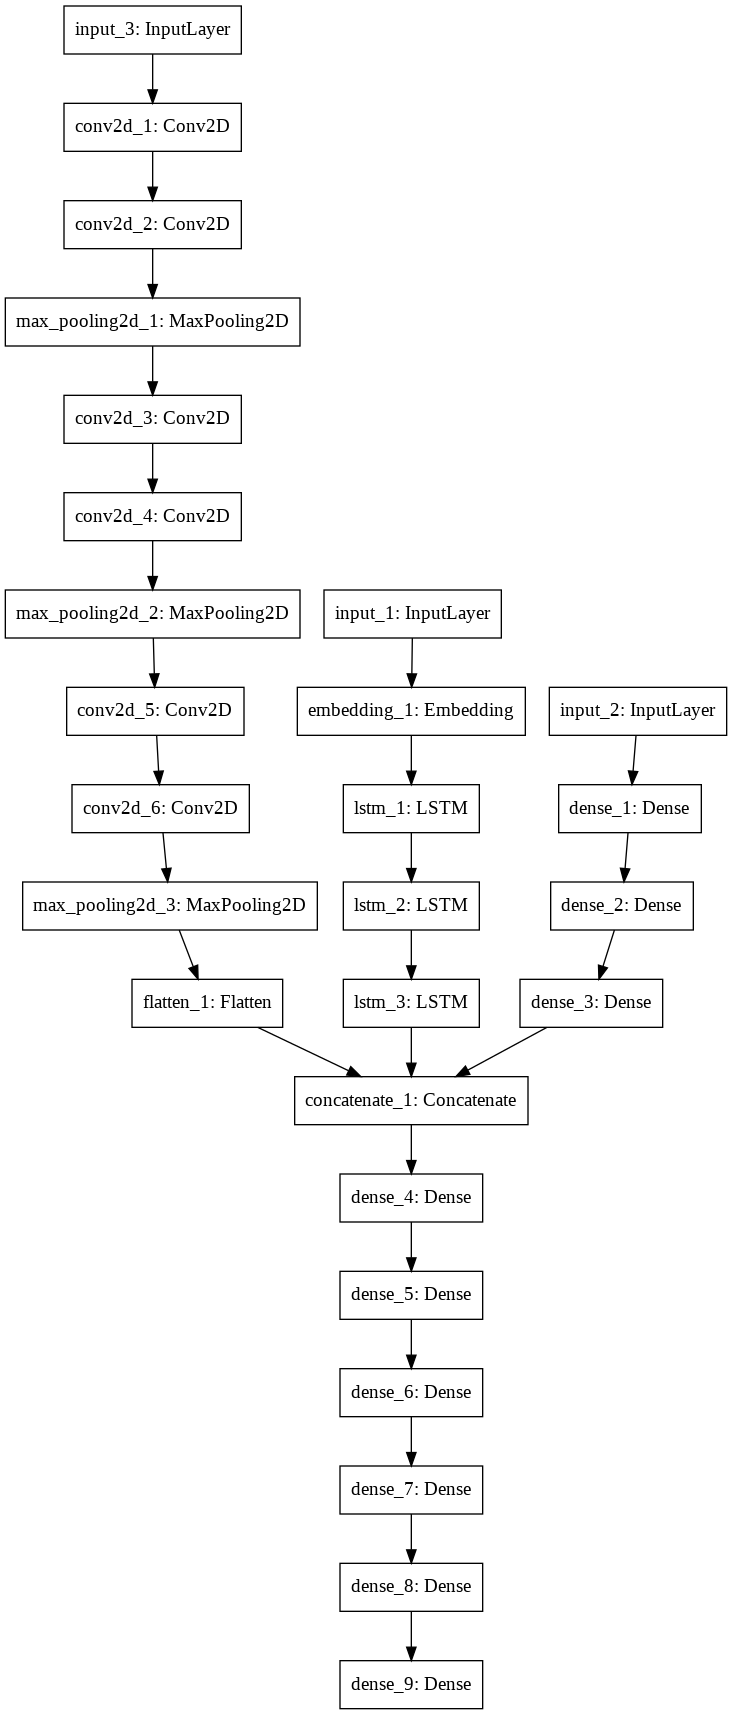

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')


In [0]:
train_x = [np.asarray(xs_texts['train']), np.asarray(xs_categoricals['train']), np.asarray(xs_images['train'])]
validation_data = ([np.asarray(xs_texts['validation']), np.asarray(xs_categoricals['validation']), np.asarray(xs_images['validation'])], np.asarray(ys['validation']))

In [32]:
from keras import optimizers

adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_x, np.asarray(ys['train']), validation_data=validation_data, epochs=20, batch_size=64)

Train on 4197 samples, validate on 1755 samples
Epoch 1/20
4197/4197 [==============================] - 77s 18ms/step - loss: 0.9169 - acc: 0.5826 - val_loss: 0.8609 - val_acc: 0.6057
Epoch 2/20
4197/4197 [==============================] - 62s 15ms/step - loss: 0.8689 - acc: 0.5878 - val_loss: 0.8365 - val_acc: 0.6057
Epoch 3/20
4197/4197 [==============================] - 62s 15ms/step - loss: 0.8650 - acc: 0.5878 - val_loss: 0.8421 - val_acc: 0.6057
Epoch 4/20
4197/4197 [==============================] - 63s 15ms/step - loss: 0.8606 - acc: 0.5878 - val_loss: 0.8327 - val_acc: 0.6057
Epoch 5/20
4197/4197 [==============================] - 64s 15ms/step - loss: 0.8528 - acc: 0.5880 - val_loss: 0.8387 - val_acc: 0.6057
Epoch 6/20
4197/4197 [==============================] - 63s 15ms/step - loss: 0.8445 - acc: 0.5947 - val_loss: 0.8317 - val_acc: 0.6028
Epoch 7/20
4197/4197 [==============================] - 63s 15ms/step - loss: 0.8189 - acc: 0.6038 - val_loss: 0.8522 - val_acc: 0.6006


**Pre-trained Model**
Now we use VGG16 model to extract features from our images.

In [34]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image as keras_image
from keras.applications.vgg16 import preprocess_input

vgg16_model = VGG16(weights='imagenet', include_top=False)
vgg16_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [53]:
xs_images = {'train': [], 'validation': []}

for image_data in train_list:
  try:
    image = keras_image.load_img(image_data['filepath'], target_size=(224, 224))
  except Exception as e:
    print(e)
    continue

  image = preprocess_image(image)
  image = np.expand_dims(image, axis=0)
  features = vgg16_model.predict(image)
  ff = features.flatten()
  xs_images['train'].append(ff)

for image_data in validation_list:
  try:
    image = keras_image.load_img(image_data['filepath'], target_size=(224, 224))
  except Exception as e:
    print(e)
    continue
    
  image = preprocess_image(image)
  image = np.expand_dims(image, axis=0)
  features = vgg16_model.predict(image)
  ff = features.flatten()
  xs_images['validation'].append(ff)


cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/sexist_meme4_640x700.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/gene_85YOUR-ARGUMENT-IS-INVALID-meme-collection-1mut.com-1.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/minion_Minion-gift-to-baby-ghost-halloween-meme-635x529.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral/minion_funny-minions-03000o-5.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/best_2017_meme-costumes-2017-great-funny-halloween-costumes-2017-memes-of-meme-costumes-2017.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/jim_got-to-love-jim-carrey_gp_2415921.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/gene_59157598.jp

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral/spiderman_60s-spiderman-meme-collection-1mut.com-8.png'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/neutral/bean_whats-is-the-face-expression-of-mr-bean-hahahah-mr-bean-meme-on-me.png'


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/jim_alright_y_then_by_girlgamer1397-d5kyqxy.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/bean_mr-bean-face-imgflip.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/best_2017_meme-costumes-2017-admirable-2017-pun-halloween-costume-ideas-saltypun-of-meme-costumes-2017.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/negative/third_Skeptical-Third-World-Kid-meme-collection-1mut.com-16.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/harvey_14.jpg'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/chuck_Hilarious-Chuck-Norris-Memes-Ever-2-1024x671.png'
cannot identify image file '/content/gdrive/My Drive/memotion_analysis/dataset/train/positive/minion_66c264447c7

In [0]:
IMAGE_SHAPE = xs_images['train'][0].shape

In [0]:
# Sanity check
assert (len(ys['train']) == len(xs_images['train']) == len(xs_texts['train']) == len(xs_categoricals['train'])),"There is some problem."
assert (len(ys['validation']) == len(xs_images['validation']) == len(xs_texts['validation']) == len(xs_categoricals['validation'])),"There is some problem."

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
from keras.models import Model


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='Text_Input')
embedded_sequences = embedding_layer(sequence_input)
lstm = LSTM(128, return_sequences=True)(embedded_sequences)
lstm = LSTM(128, return_sequences=True)(lstm)
lstm = LSTM(128, name='LSTM_Output')(lstm)

categorical_input = Input(shape=(4,), name='Categorical_Input')
x = Dense(128, activation='relu')(categorical_input)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu', name='Categorical_Output')(x)

image_input = Input(shape=IMAGE_SHAPE, name='VGG16_Image_Input')
y = Dense(256, activation='relu')(image_input)
y = Dense(128, activation='relu')(y)
y = Dense(64, activation='relu')(y)
y = Dense(64, activation='relu')(y)
y = Dense(128, activation='relu', name='Image_Output')(y)

merged = concatenate([lstm, x, y])
x = Dense(128, activation='relu')(merged)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=[sequence_input, categorical_input, image_input], outputs=[output])

In [61]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VGG16_Image_Input (InputLayer)  (None, 25088)        0                                            
__________________________________________________________________________________________________
Text_Input (InputLayer)         (None, 104)          0                                            
__________________________________________________________________________________________________
dense_92 (Dense)                (None, 256)          6422784     VGG16_Image_Input[0][0]          
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 104, 100)     1084500     Text_Input[0][0]                 
____________________________________________________________________________________________

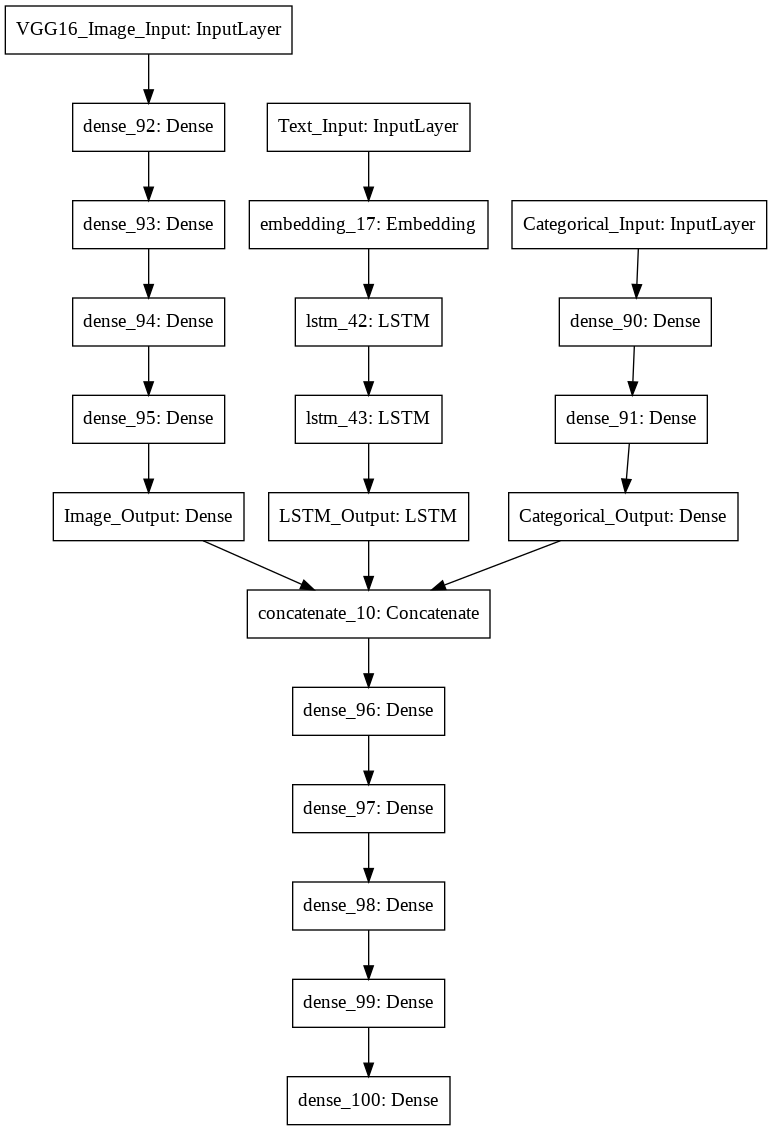

In [62]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')


In [0]:
train_x[2] = np.asarray(xs_images['train'])
validation_data[0][2] = np.asarray(xs_images['validation'])

**Assigning weights** Number of negative class images are high enough compared to other labels. So we assign weights in order to balance data training.


In [0]:
from sklearn.utils import class_weight


y_train = np.asarray(ys['train'])
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.ravel(y_train,order='C')),
                                                 np.ravel(y_train,order='C'))

In [87]:
from keras import optimizers
optimizer = optimizers.Adam(lr=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_x, np.asarray(ys['train']), validation_data=validation_data, epochs=20, batch_size=64, class_weight=class_weights)

Train on 4197 samples, validate on 1755 samples
Epoch 1/20
4197/4197 [==============================] - 53s 13ms/step - loss: 0.8896 - acc: 0.5792 - val_loss: 0.8289 - val_acc: 0.6057
Epoch 2/20
4197/4197 [==============================] - 40s 10ms/step - loss: 0.8596 - acc: 0.5876 - val_loss: 0.8276 - val_acc: 0.6057
Epoch 3/20
4197/4197 [==============================] - 40s 10ms/step - loss: 0.8428 - acc: 0.5928 - val_loss: 0.8415 - val_acc: 0.6057
Epoch 4/20
4197/4197 [==============================] - 41s 10ms/step - loss: 0.8184 - acc: 0.6000 - val_loss: 0.8630 - val_acc: 0.5852
Epoch 5/20
4197/4197 [==============================] - 41s 10ms/step - loss: 0.7822 - acc: 0.6238 - val_loss: 0.8656 - val_acc: 0.6177
Epoch 6/20
4197/4197 [==============================] - 42s 10ms/step - loss: 0.7208 - acc: 0.6521 - val_loss: 1.0762 - val_acc: 0.4558
Epoch 7/20
4197/4197 [==============================] - 41s 10ms/step - loss: 0.6496 - acc: 0.6981 - val_loss: 0.9892 - val_acc: 0.5054


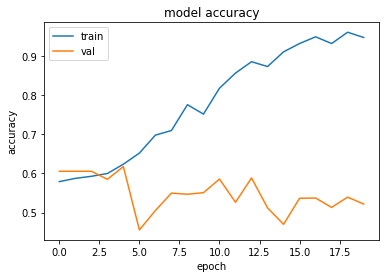

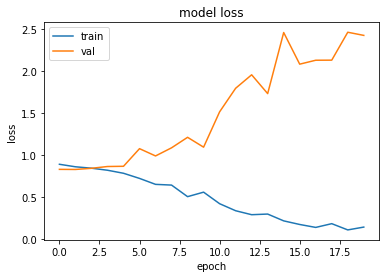

In [88]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
